# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
%matplotlib inline

In [3]:
import warnings
from matplotlib import rc
rc('text', usetex=True)
warnings.filterwarnings('ignore')

In [4]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy

import warnings

import matplotlib as mpl


In [5]:
mpl.rcParams.update(
{
    # figure
    'figure.figsize':   (10, 10),
    
    # axes
    'axes.labelsize': 24,
    
    # title
    'axes.titlesize':28,
    
    # ticks
    'xtick.major.size':  5,
    'xtick.minor.size':  2.5,
    'xtick.major.width': 0.8,
    'xtick.minor.width': 0.6,
    'xtick.labelsize':   20,
    
    'ytick.major.size':  5,
    'ytick.minor.size':  2.5,
    'ytick.major.width': 0.8,
    'ytick.minor.width': 0.6,
    'ytick.labelsize':   20,
    
    #legend
    'legend.fontsize': 24,

})

# Load data

In [6]:
from relaxed.analysis import setup, get_am

In [7]:
# catalog
hcat, indices, scales = setup('m11', path='../temp')
cvir = hcat.cat['cvir']

In [8]:
# obtain a_m
am, mass_bins = get_am('m11', min_mass=0.1, path='../temp')

# throw away last, useless bin (a = 1.00 always for that)
am = am[:, 1:-1]
mass_bins = mass_bins[1:-1]
print(am.shape)

(9999, 98)


# Histogram of NaNs

## m11

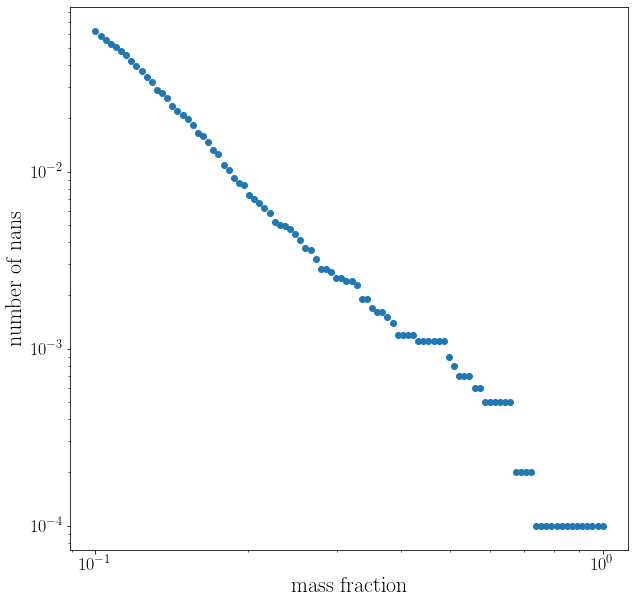

In [120]:
plt.figure(figsize=(10,10))
count_nans = np.array([ (sum(np.isnan(am[:, i]))+1)/(9999-sum(np.isnan(am[:,i]))) for i in range(len(mass_bins))])
plt.scatter(mass_bins, count_nans)
plt.xlabel('\\rm mass fraction', size=22)
plt.ylabel('\\rm number of nans', size=22)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=18)
plt.show()

## m12

In [65]:
hcat_12, indices, scales = setup('m12', path='../temp')
am_12, mass_bins_12 = get_am('m12', min_mass=0.1, path='../temp')

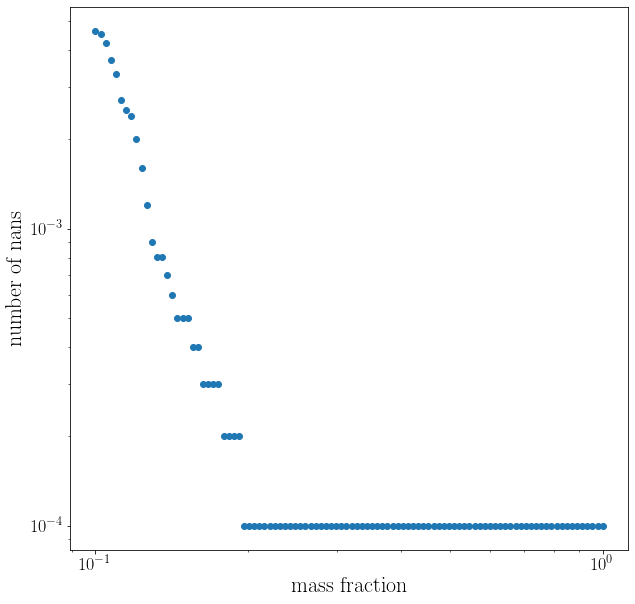

In [66]:
plt.figure(figsize=(10,10))
count_nans = np.array([ (sum(np.isnan(am_12[:, i]))+1)/(9999-sum(np.isnan(am_12[:,i]))) for i in range(len(mass_bins_12))])
plt.scatter(mass_bins_12, count_nans)
plt.xlabel('\\rm mass fraction', size=22)
plt.ylabel('\\rm number of nans', size=22)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=18)
plt.show()

# Test normality (with probplots)

## Example of normal distribution

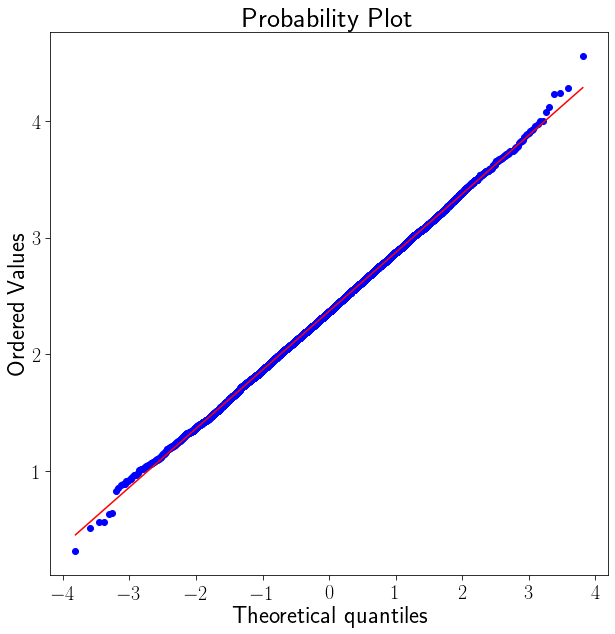

In [64]:
from scipy import stats

x = np.random.randn(10000)*np.std(np.log(cvir)) + np.mean(np.log(cvir))
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
res = stats.probplot(x, dist='norm', plot=ax)



## log c_vir

In [14]:
# use a normaltest to check (H0 = is Gaussian, H1 = not Gaussian)
from scipy.stats import normaltest
k2, p = normaltest(np.log(cvir))
alpha = 1e-3
print(f'cannot reject null hypothesis' if alpha < p else 'reject null hypothesis')
print('p-value:', p)

reject null hypothesis
p-value: 2.2259140416470982e-130


Text(0.5, 1.0, 'Probability Plot for $\\log c_{\\rm vir}$')

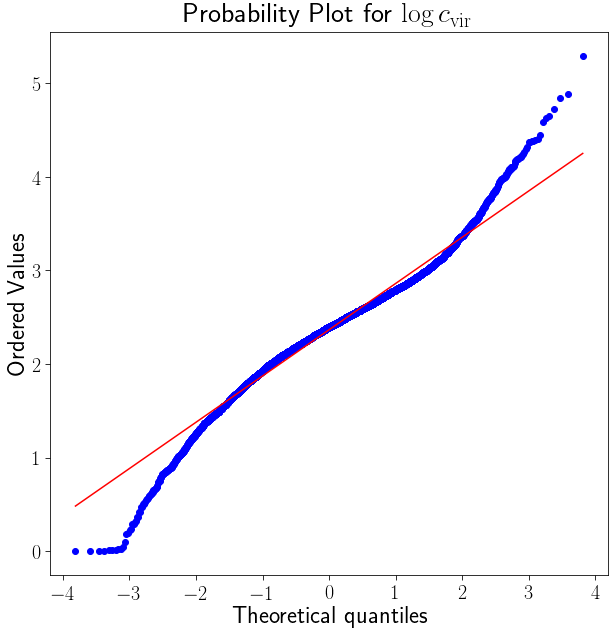

In [35]:
from scipy import stats

x = np.log(cvir)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
res = stats.probplot(x, dist='norm', plot=ax)
ax.set_title(r"Probability Plot for $\log c_{\rm vir}$")

# close enough!

## a_m_i

(array([1.000e+00, 0.000e+00, 1.000e+00, 5.000e+00, 1.600e+01, 4.500e+01,
        2.330e+02, 1.263e+03, 4.386e+03, 3.720e+03]),
 array([-1.64248733, -1.41437381, -1.18626029, -0.95814677, -0.73003325,
        -0.50191973, -0.27380621, -0.04569269,  0.18242082,  0.41053434,
         0.63864786]),
 <a list of 10 Patch objects>)

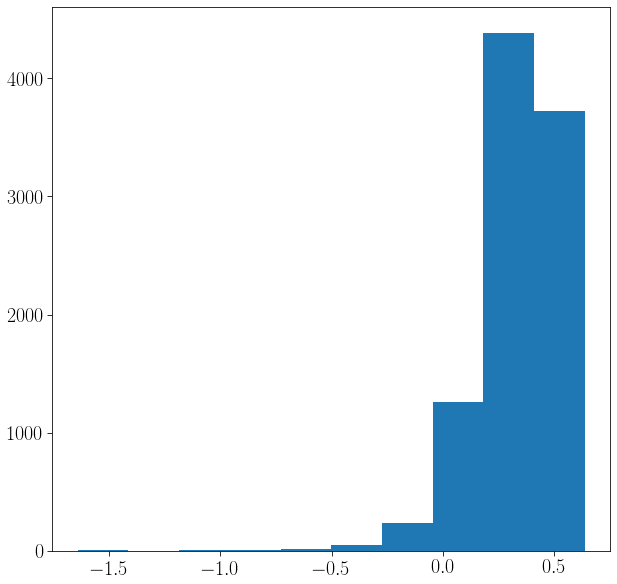

In [69]:
plt.hist(x)

In [92]:
mass_bins[85]

0.7220809018385465

9670


Text(0.5, 1.0, 'Probability Plot for $a(m_i=0.13)$')

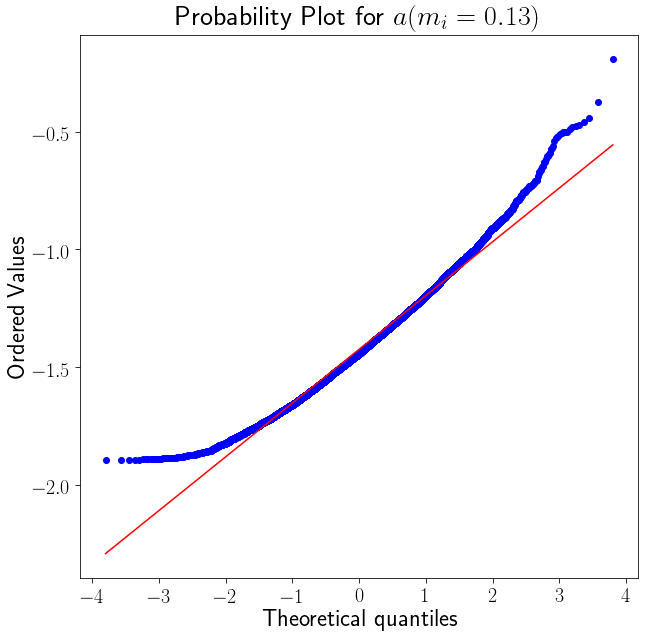

In [105]:

from scipy import stats
idx = 10
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
x = np.log(am[:, idx])
m= mass_bins[idx]
keep = ~np.isnan(x)
x = x[keep]
print(sum(keep))
res = stats.probplot(x, dist='norm', plot=ax, fit=True)
ax.set_title(f"Probability Plot for $a(m_i={m:.2f})$")


# becomes more non-Gaussian as m_i -> 0 or m_i -> 1 

## Histograms

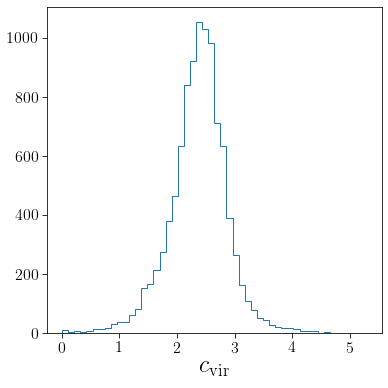

In [15]:
# looks Gaussian already
plt.figure(figsize=(6,6))
plt.hist(np.log(cvir), bins=50, histtype='step');
plt.xlabel("$c_{\\rm vir}$", size=24)
plt.tick_params(which='both', labelsize=16)


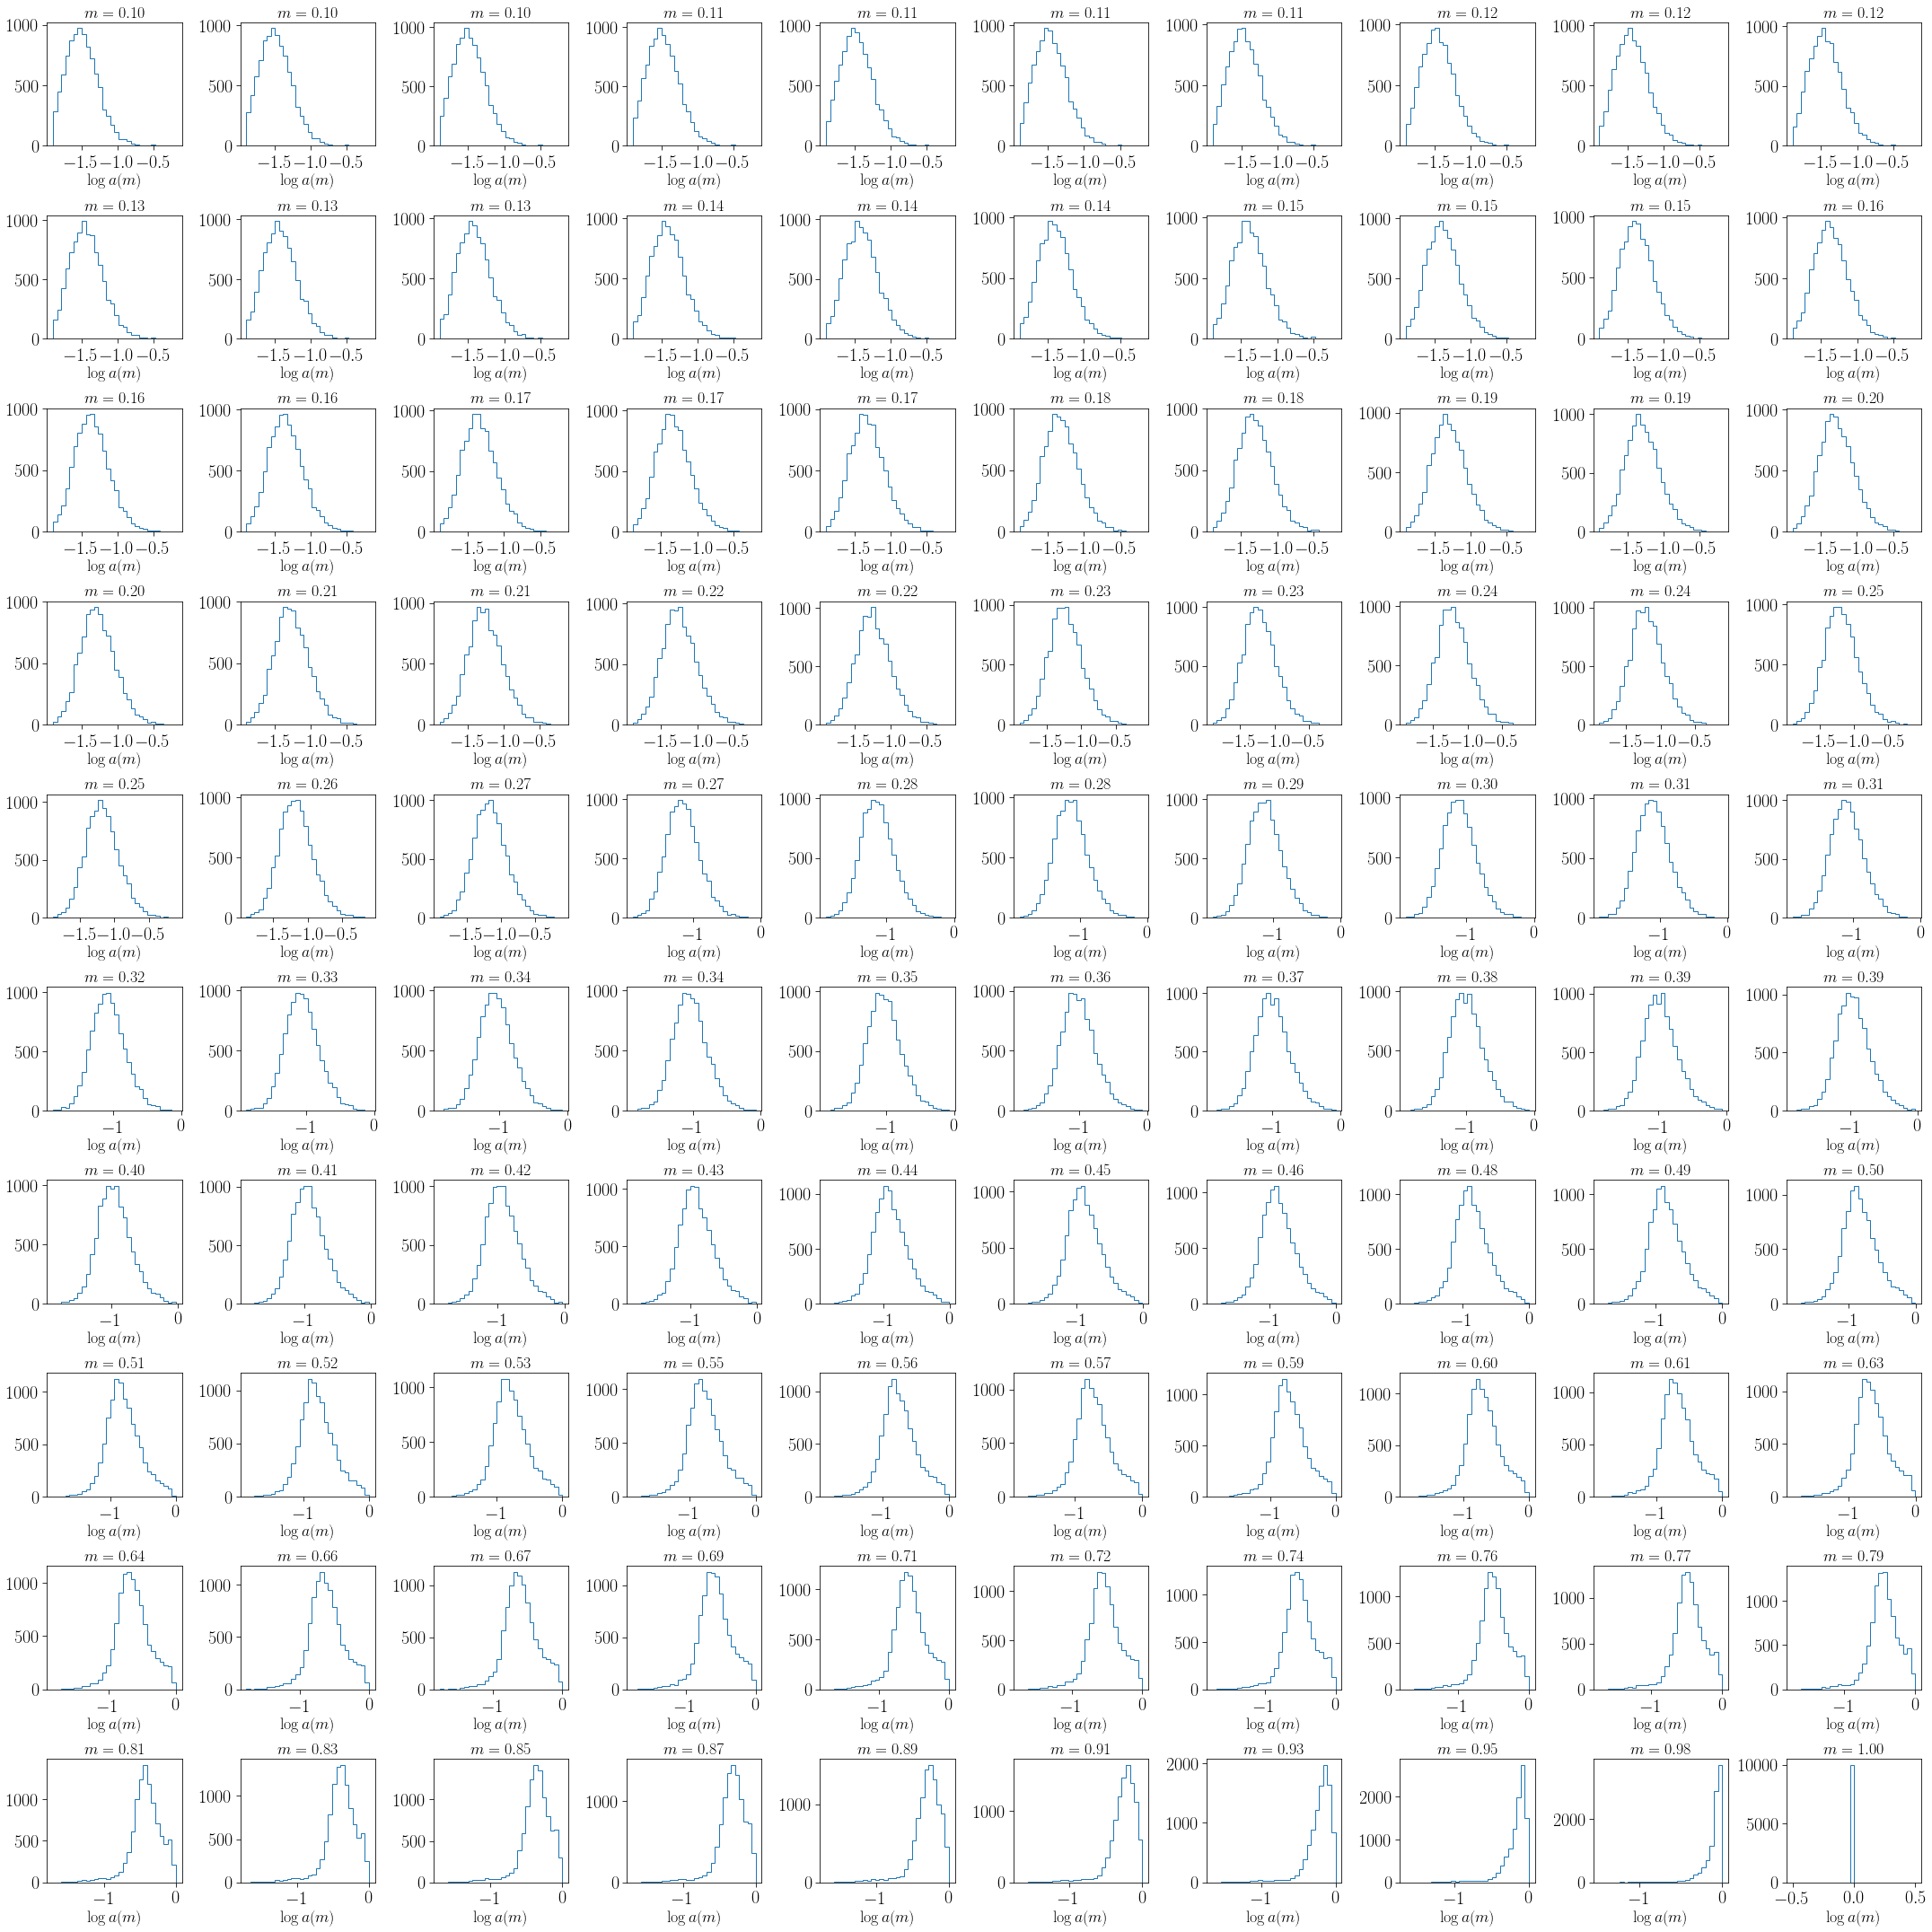

In [16]:
fig, axes = plt.subplots(10, 10, figsize=(30, 30))
axes = axes.flatten()

for i in range(100): 
    ax = axes[i]
    mass_bin = mass_bins[i]
    ax.hist(np.log(am[:, i]), histtype='step', bins=30)
    ax.set_title(f"$m={mass_bin:.2f}$", size=18)
    ax.set_xlabel("$\\log a(m)$", size=18)
plt.tight_layout()

# Correlations between a_m(i)

In [56]:
from scipy.stats import spearmanr
n_mbins = 100
corrs = np.zeros((n_mbins, n_mbins))
for i in range(n_mbins):
    for j in range(n_mbins):
        corrs[i,j] = spearmanr(am[:,i], am[:, j], nan_policy='omit')[0]

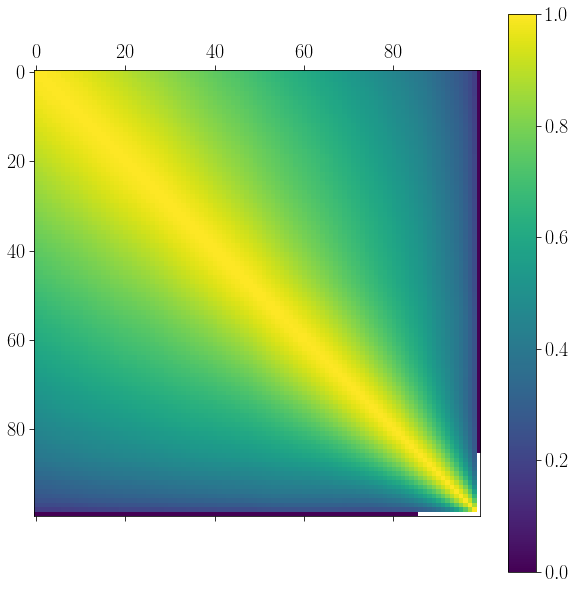

In [61]:
plt.matshow(corrs)
plt.colorbar()

In [122]:
mass_bins

array([0.1       , 0.1023531 , 0.10476158, 0.10722672, 0.10974988,
       0.1123324 , 0.1149757 , 0.1176812 , 0.12045035, 0.12328467,
       0.12618569, 0.12915497, 0.13219411, 0.13530478, 0.13848864,
       0.14174742, 0.14508288, 0.14849683, 0.15199111, 0.15556761,
       0.15922828, 0.16297508, 0.16681005, 0.17073526, 0.17475284,
       0.17886495, 0.18307383, 0.18738174, 0.19179103, 0.19630407,
       0.2009233 , 0.20565123, 0.21049041, 0.21544347, 0.22051307,
       0.22570197, 0.23101297, 0.23644894, 0.24201283, 0.24770764,
       0.25353645, 0.25950242, 0.26560878, 0.27185882, 0.27825594,
       0.28480359, 0.29150531, 0.29836472, 0.30538555, 0.31257158,
       0.31992671, 0.32745492, 0.33516027, 0.34304693, 0.35111917,
       0.35938137, 0.36783798, 0.37649358, 0.38535286, 0.39442061,
       0.40370173, 0.41320124, 0.42292429, 0.43287613, 0.44306215,
       0.45348785, 0.46415888, 0.47508102, 0.48626016, 0.49770236,
       0.5094138 , 0.52140083, 0.53366992, 0.54622772, 0.55908

# Algorithm

In [108]:
from scipy import stats
from scipy.stats import spearmanr

def get_quantiles(arr):
    return np.vectorize(lambda x: stats.percentileofscore(arr, x))(arr) / 100.

def gaussian_conditional(x, lam, ind=False):
    # x represents one of the dark matter halo properties at z=0. 
    # x and log(am) is assumed to be Gaussian.
    
    n_bins = lam.shape[1]
    assert len(x.shape)==1
    assert lam.shape == (x.shape[0], n_bins)
    
    # calculate sigma/correlation matrix bewteen all quantitie
    z = np.vstack([x.reshape(1,  -1), lam.T]).T
    assert z.shape == (x.shape[0], n_bins+1)
    np.testing.assert_equal(x, z[:, 0])
    np.testing.assert_equal(lam[:, 0], z[:, 1]) # ignore mutual nan's
    np.testing.assert_equal(lam[:, -1], z[:, -1])
    
    # calculate covariances
    Sigma = np.zeros((1 + n_bins, 1 + n_bins))
    rho = np.zeros((1 + n_bins, 1 + n_bins))
    for i in range(n_bins+1):
        for j in range(n_bins+1):
            if i <= j:
                z1, z2 = z[:, i], z[:, j]
                keep = ~np.isnan(z1) & ~np.isnan(z2)
                cov = np.cov(z1[keep], z2[keep])
                assert cov.shape == (2, 2)
                Sigma[i, j] = cov[0, 1]
                rho[i, j] = np.corrcoef(z1[keep], z2[keep])[0, 1]
            else: 
                rho[i, j] = rho[j, i]
                Sigma[i, j] = Sigma[j, i]

                
    # we assume a multivariate-gaussian distribution P(X, a(m1), a(m2), ...) with
    # conditional distribution P(X | {a(m_i)}) uses the rule here: 
    # https://stats.stackexchange.com/questions/30588/deriving-the-conditional-distributions-of-a-multivariate-normal-distribution
    # we return the mean/std deviation of the conditional gaussian.
    assert np.all(~np.isnan(Sigma))
    assert np.all(~np.isnan(rho))
    
    mu1 = np.nanmean(z[:, 0]).reshape(1, 1)
    mu2 = np.nanmean(lam, axis=0).reshape(n_bins, 1)
    Sigma11 = Sigma[0, 0].reshape(1, 1)
    Sigma12 = Sigma[0, 1:].reshape(1, n_bins)
    Sigma22 = Sigma[1:, 1:].reshape(n_bins, n_bins)
    
    if ind: 
        for i in range(Sigma22.shape[0]):
            for j in range(Sigma22.shape[1]):
                if i!=j:
                    Sigma22[i, j]= 0
    
    def mu_cond(lam_test):
        assert np.sum(np.isnan(lam_test)) == 0
        lam_test = lam_test.reshape(-1, n_bins).T
        mu_cond = mu1 + Sigma12.dot(np.linalg.inv(Sigma22)).dot(lam_test-mu2)
        return mu_cond.reshape(-1)
    
    sigma_cond = Sigma11 - Sigma12.dot(np.linalg.inv(Sigma22)).dot(Sigma12.T)
    
    return mu1, mu2, Sigma, rho, mu_cond, sigma_cond

## Try producing some synthetic data to test algorithm

In [109]:
mean = np.array([1, 0])
cov = np.array([[1, 0.99], [0.99, 1]])
x, y = np.random.multivariate_normal(mean, cov, 5000).T
# we should easily be able to condition on x and get y very precisely with some small scatter (~around 0.5)

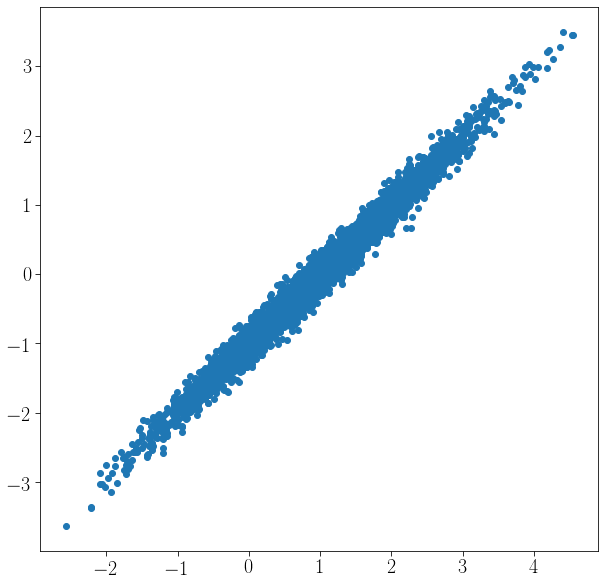

In [44]:
# display synthetic data
plt.scatter(x,y)

In [45]:
x_train = x[:4000]
x_test = x[4000:]

y = y.reshape(-1, 1)
y_train = y[:4000]
y_test = y[4000:]

print(x_test.shape, y_test.shape)

(1000,) (1000, 1)


In [46]:
mu1, mu2, Sigma, rho, mu_cond, sigma_cond = gaussian_conditional(x_train, y_train)

In [48]:
x_pred = mu_cond(y_test)

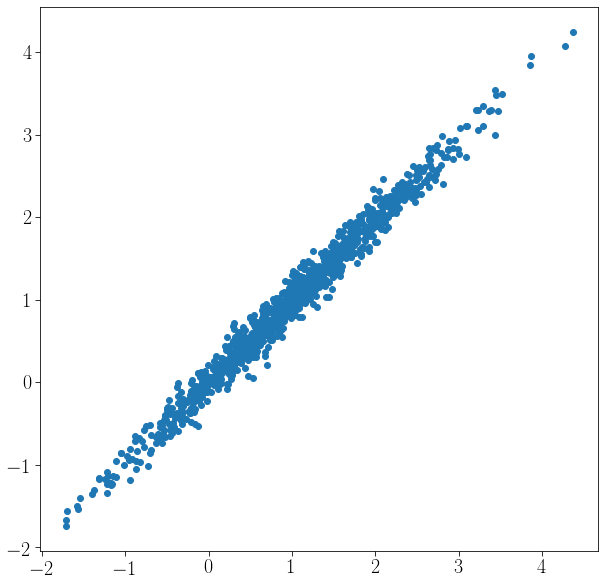

In [49]:
plt.scatter(x_test, x_pred)

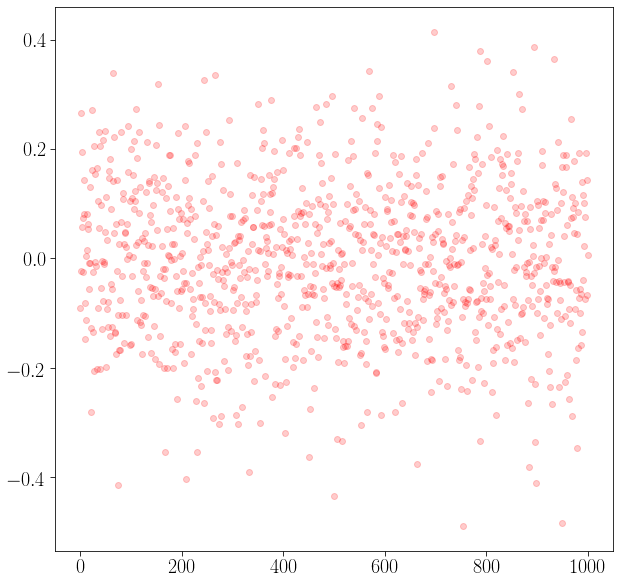

In [50]:
plt.plot(x_pred - x_test, 'ro', alpha=0.2)

## Test on real c_vir

In [140]:
# separate into train/validation set. 
lam =  np.log(am)

# for testing set, pick from haloes that do not have NaNs in their a(m) history. 
# since the training ones it's a lot easier to handle the NaNs consistently and not throw away data points.
assert np.sum(np.isnan(np.log(cvir))) == 0
keep = np.ones(len(lam), dtype=bool)
for i in range(len(lam)):
    keep[i] = ~np.any(np.isnan(lam[i, :]))
test_indices = np.random.choice(np.where(keep)[0], size=1000, replace=False)
train_indices = list(set(range(len(lam))) - set(test_indices))

cvir_test = cvir[test_indices]
cvir_train = cvir[train_indices]

lam_test = lam[test_indices]
lam_train = lam[train_indices]


assert np.sum(np.isnan(lam_test)) == 0
assert lam_test.shape == (1000, 98)
assert lam_train.shape == (8999, 98)

In [141]:
mu1, mu2, Sigma, rho, mu_cond, sigma_cond = gaussian_conditional(np.log(cvir_train), lam_train)
assert callable(mu_cond)

### See correlation coefficients (from covariance matrix, not spearman)

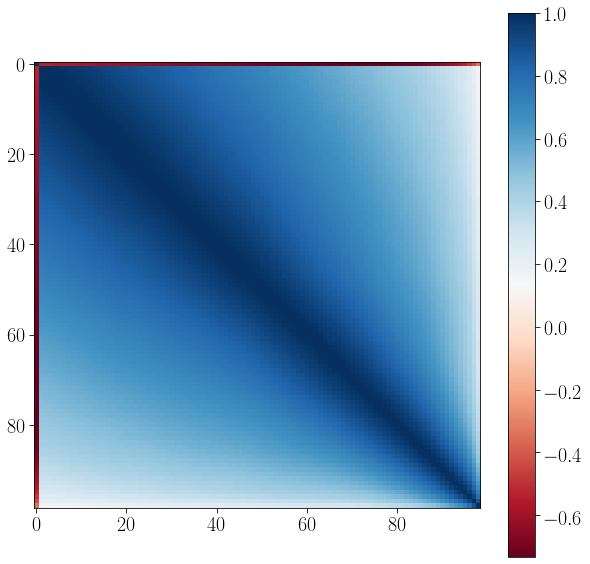

In [142]:
plt.imshow(rho, cmap='RdBu')
plt.colorbar()

### Test on held out data

In [143]:
log_cvir_pred = mu_cond(lam_test)
print(log_cvir_pred.shape)

(1000,)


Text(0, 0.5, '$\\rm counts$')

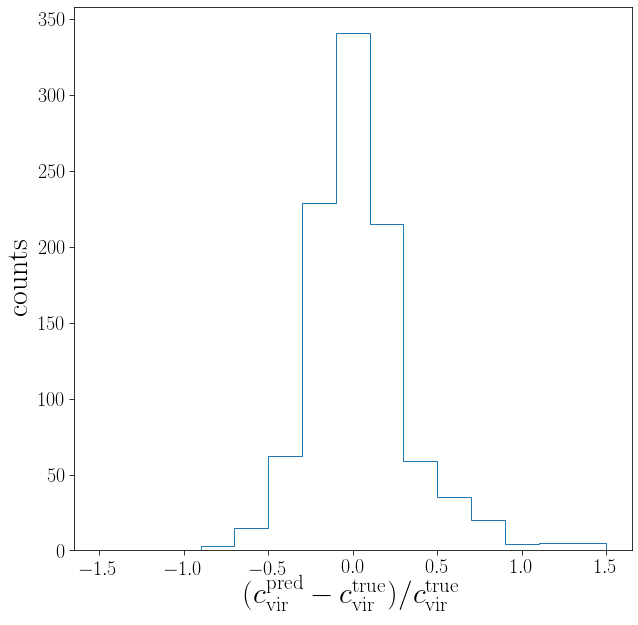

In [144]:
cvir_pred = np.exp(log_cvir_pred)

plt.hist( (cvir_pred - cvir_test) / cvir_test , histtype='step', bins=15, range=(-1.5, 1.5))
plt.xlabel(r"$(c_{\rm vir}^{\rm pred} - c_{\rm vir}^{\rm true})/ c_{\rm vir}^{\rm true}$", size=30)
plt.ylabel(r"$\rm counts$", size=30)

In [145]:
import scipy
scipy.stats.spearmanr(cvir_pred, cvir_test)[0]

0.7875130155130157

### comparsion with baseline method.

Text(0.5, 1.0, '$c_{\\rm vir}^{\\rm pred} \\sim LN(\\mu^{\\rm true}, \\sigma^{\\rm true})$')

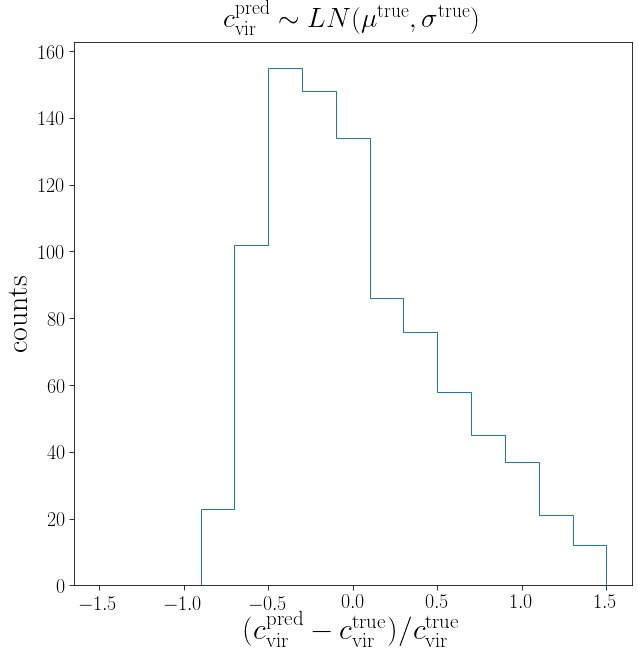

In [67]:
# sampling from lognormal with mean/var equal to true distribution.
log_cvir_pred = np.random.normal(np.mean(np.log(cvir)), np.std(np.log(cvir)), 1000)
cvir_pred = np.exp(log_cvir_pred)

plt.hist( (cvir_pred - cvir_test) / cvir_test , histtype='step', bins=15, range=(-1.5, 1.5))
plt.xlabel(r"$(c_{\rm vir}^{\rm pred} - c_{\rm vir}^{\rm true})/ c_{\rm vir}^{\rm true}$", size=30)
plt.ylabel(r"$\rm counts$", size=30)
plt.title(r"$c_{\rm vir}^{\rm pred} \sim LN(\mu^{\rm true}, \sigma^{\rm true})$")


In [68]:
scipy.stats.spearmanr(cvir_pred, cvir_test)

SpearmanrResult(correlation=0.06417254817254818, pvalue=0.04247178588119803)

### Ranks using a1/2

In [84]:
idx = np.where((0.498 < mass_bins) & (mass_bins < 0.51) )[0].item()
a_2 = am[:, idx]
print(a_2.shape)

a_2_train = a_2[train_indices]
a_2_test = a_2[test_indices]

print(a_2_train.shape)

(9999,)
(8999,)


In [89]:
sum(sorted_idx==8999)

87

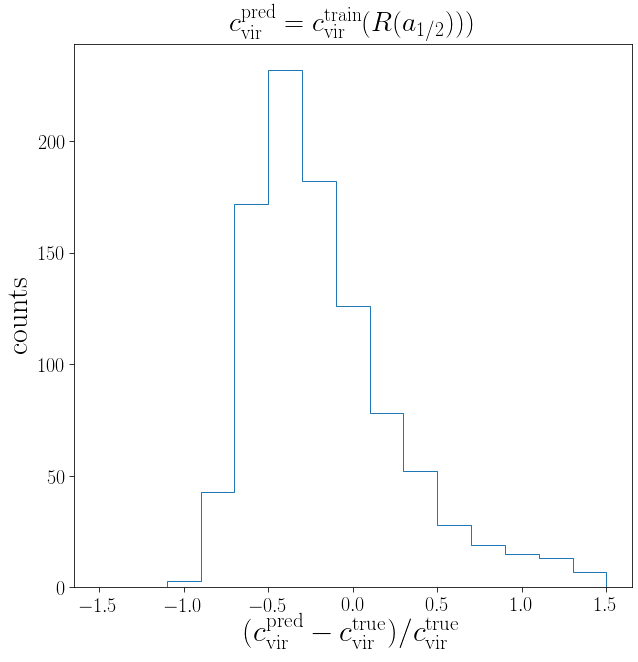

In [97]:
# where do we need to insert each id in sub_pids to keep host_ids ordered.
sorted_idx = np.searchsorted(a_2_train, a_2_test)

#for the ones that are bigger than everything, just default to the upper bound
sorted_idx[sorted_idx >= len(a_2_train)] -= len(a_2_train) - 1

#just take the corresponding cvir as pred. 
cvir_pred = cvir_train[sorted_idx]

plt.hist( (cvir_pred - cvir_test) / cvir_test , histtype='step', bins=15, range=(-1.5, 1.5))
plt.xlabel(r"$(c_{\rm vir}^{\rm pred} - c_{\rm vir}^{\rm true})/ c_{\rm vir}^{\rm true}$", size=30)
plt.ylabel(r"$\rm counts$", size=30)
plt.title(r"$c_{\rm vir}^{\rm pred} = c_{\rm vir}^{\rm train}(R(a_{1/2})))$")

plt.show()

## assume covariance between a(m_i) bins is 0

In [146]:
mu1, mu2, Sigma, rho, mu_cond, sigma_cond = gaussian_conditional(np.log(cvir_train), lam_train, ind=True)
assert callable(mu_cond)

In [147]:
log_cvir_pred = mu_cond(lam_test)
print(log_cvir_pred.shape)

(1000,)


Text(0, 0.5, '$\\rm counts$')

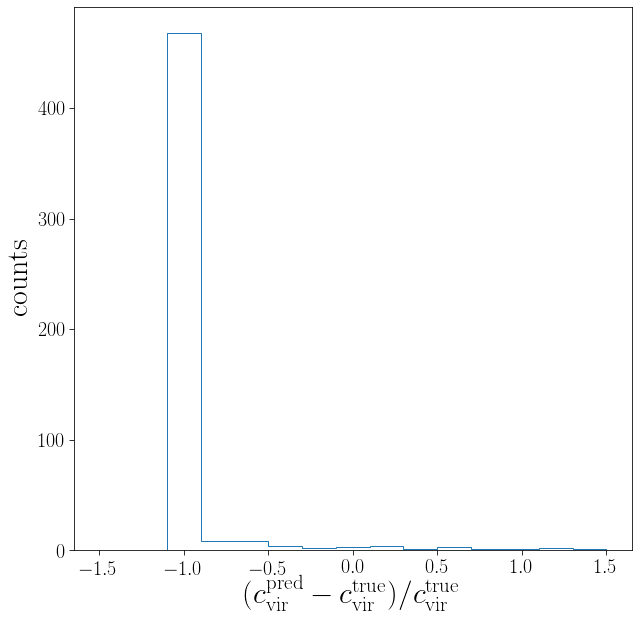

In [148]:
cvir_pred = np.exp(log_cvir_pred)

plt.hist( (cvir_pred - cvir_test) / cvir_test , histtype='step', bins=15, range=(-1.5, 1.5))
plt.xlabel(r"$(c_{\rm vir}^{\rm pred} - c_{\rm vir}^{\rm true})/ c_{\rm vir}^{\rm true}$", size=30)
plt.ylabel(r"$\rm counts$", size=30)

In [149]:
scipy.stats.spearmanr(cvir_pred, cvir_test)

SpearmanrResult(correlation=0.7649279489279489, pvalue=7.318106085259906e-193)